In [440]:
import pandas as pd
import numpy as np

In [441]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

In [442]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [443]:
df = pd.read_csv('DS_Role_DataSet.csv')

The dataset contains in a particular column descriptions for the columns that do contain data. We split description from data.

In [444]:
data_description = {}
for index, value in df.loc[pd.notnull(df['Data information']),'Data information'].iteritems():
    description = value.split(': ')
    data_description[description[0]] = description[1]

In [445]:
data_description

{'card': 'Dummy variable, 1 if application for credit card accepted, 0 if not',
 'reports': 'Number of major derogatory reports',
 'age': 'Age n years plus twelfths of a year',
 'income': 'Yearly income (divided by 10,000)',
 'share': 'Ratio of monthly credit card expenditure to yearly income',
 'expenditure': 'Average monthly credit card expenditure',
 'owner': '1 if owns their home, 0 if rent',
 'selfempl': '1 if self employed, 0 if not.',
 'dependents': '1 + number of dependents',
 'months': 'Months living at current address',
 'majorcards': 'Number of major credit cards held',
 'active': 'Number of active credit accounts'}

In [446]:
data_values = df.drop(columns=['Data information', 'Unnamed: 12'])

In [447]:
data_values

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


# Data preparation

We should handle cases when values are missing or do not correspond to an expected distribution (outliers). This dataset does not have any missing data, as we can see next.

In [448]:
data_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
card           1319 non-null object
reports        1319 non-null int64
age            1319 non-null float64
income         1319 non-null float64
share          1319 non-null float64
expenditure    1319 non-null float64
owner          1319 non-null object
selfemp        1319 non-null object
dependents     1319 non-null int64
months         1319 non-null int64
majorcards     1319 non-null int64
active         1319 non-null int64
dtypes: float64(4), int64(5), object(3)
memory usage: 123.8+ KB


Categorical data correspond to `card`, `owner` and `selfemp` columns, which we expect to have only binary values.

In [449]:
print(data_values['card'].unique())
print(data_values['owner'].unique())
print(data_values['selfemp'].unique())

['yes' 'no']
['yes' 'no']
['no' 'yes']


/home/paloderosa/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/paloderosa/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


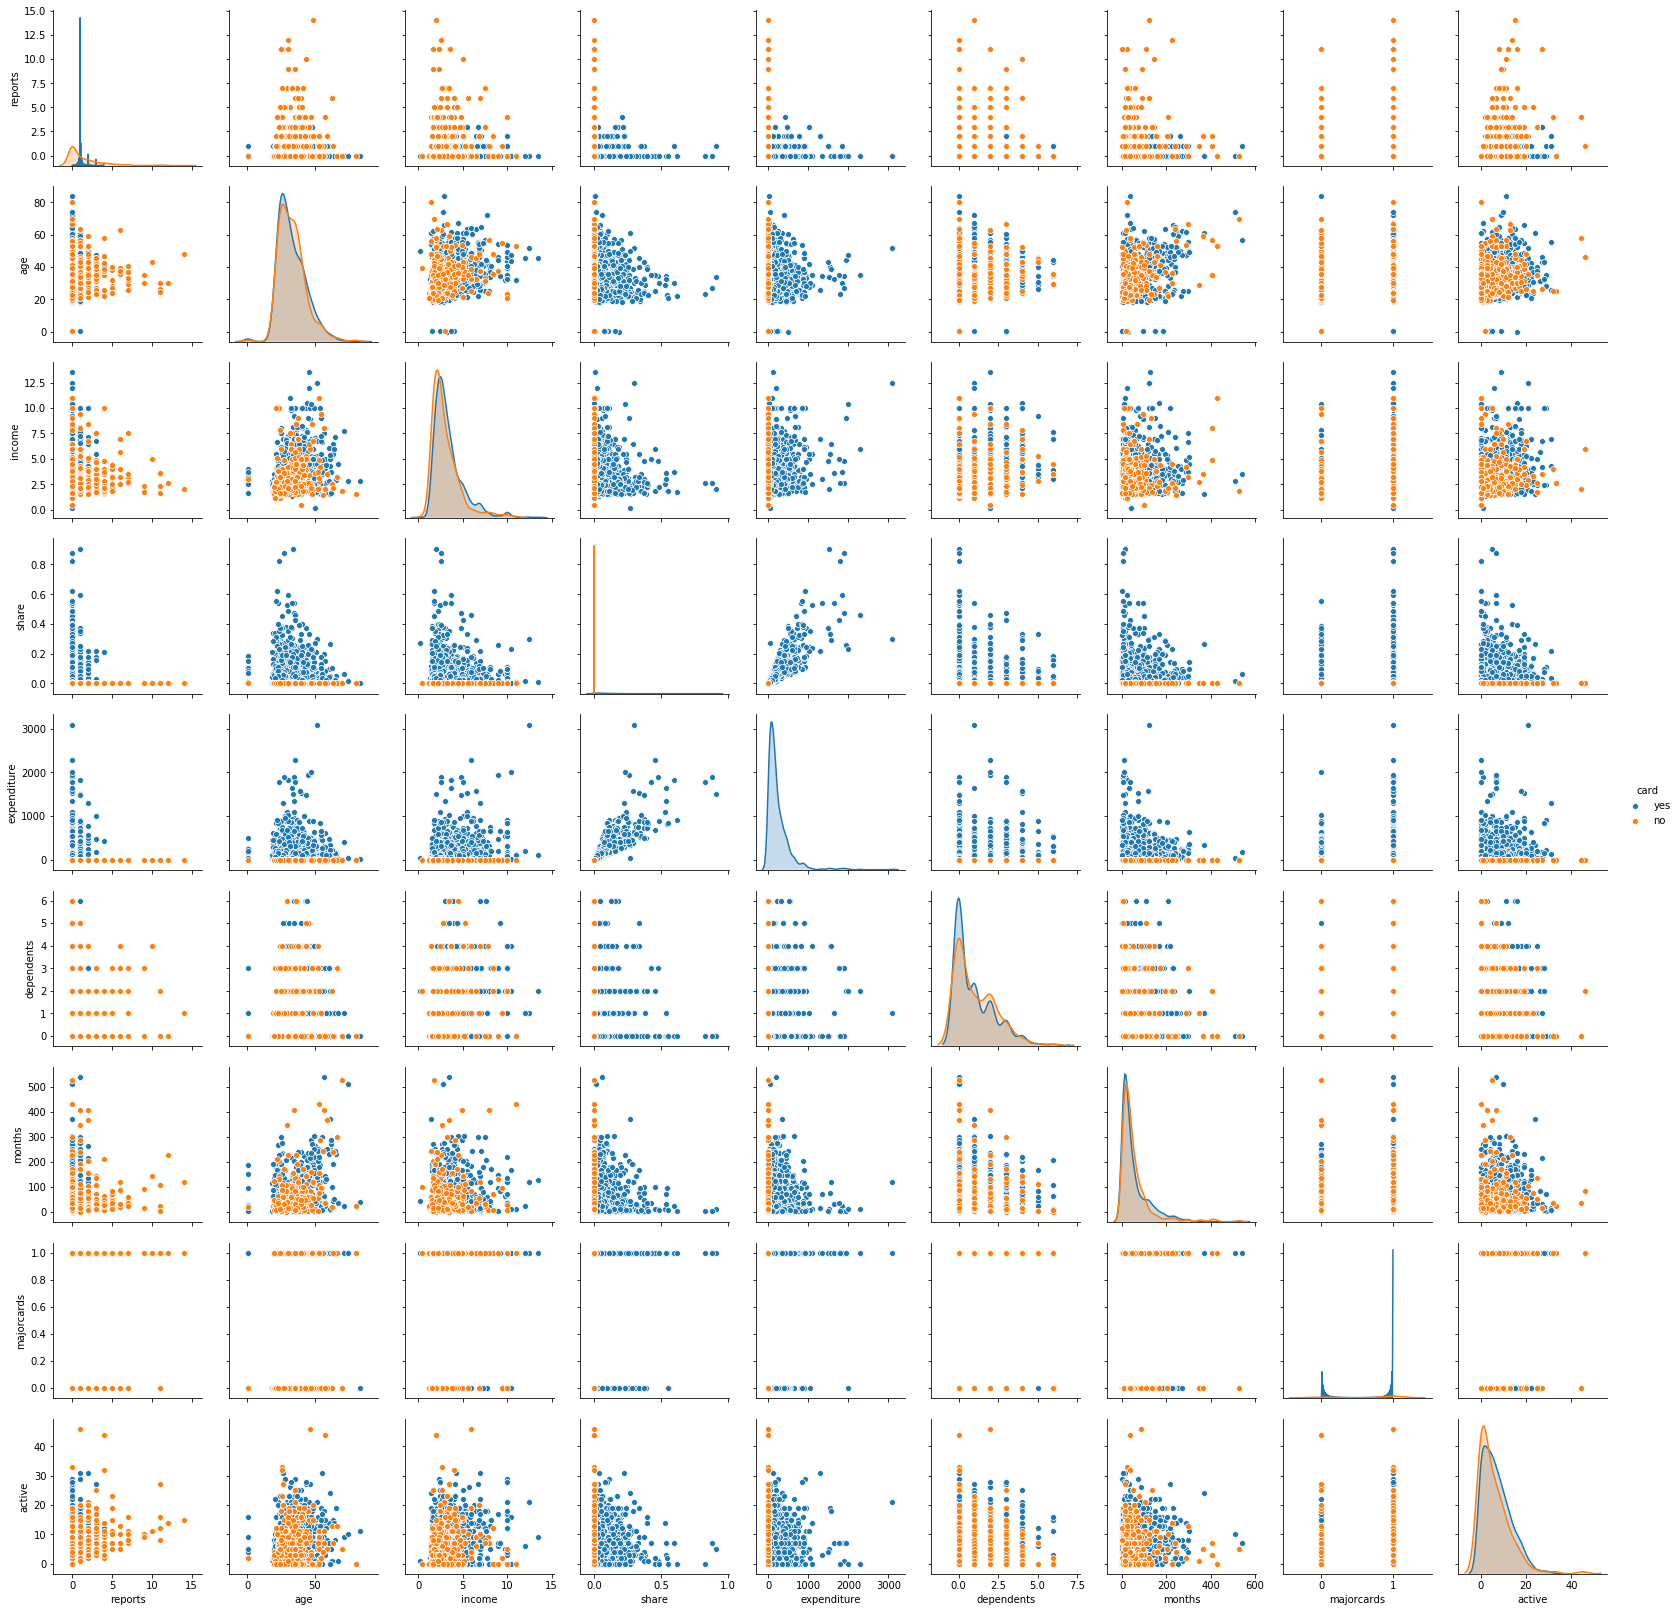

In [450]:
#fig = plt.figure(figsize=(15,15))
sns.pairplot(data_values, hue='card')

We could be very precise as to the definition of an outlier, but at first sight we do not see data points very separated from the distribution of points.

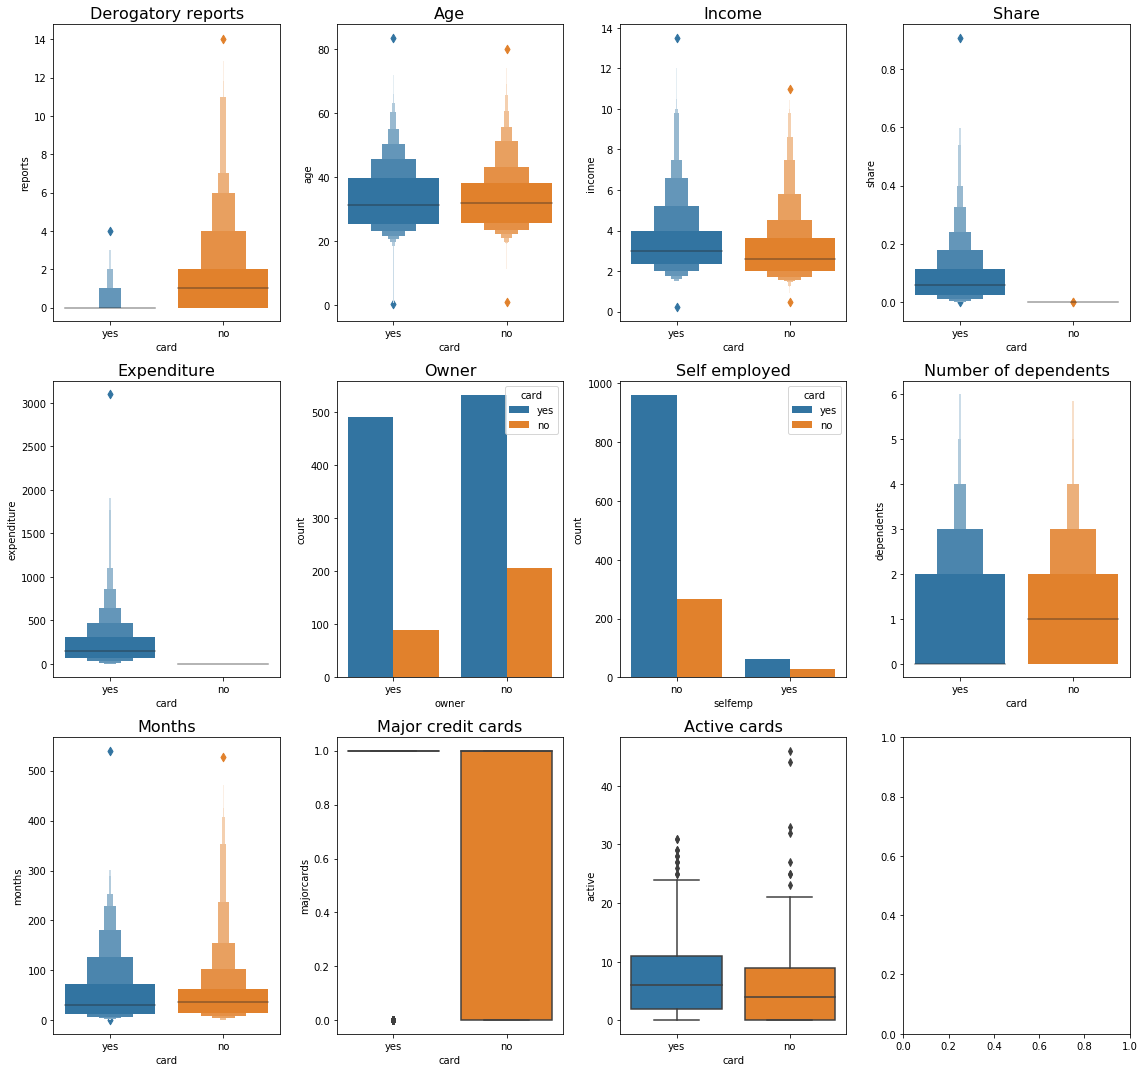

In [451]:
f, axes = plt.subplots(3, 4, figsize=(16,15))

sns.boxenplot(x='card', y='reports', data=data_values, ax=axes[0,0])
axes[0, 0].set_title("Derogatory reports", fontsize=16)

sns.boxenplot(x='card', y='age', data=data_values, ax=axes[0,1])
axes[0, 1].set_title("Age", fontsize=16)

sns.boxenplot(x='card', y='income', data=data_values, ax=axes[0,2])
axes[0, 2].set_title("Income", fontsize=16)

sns.boxenplot(x='card', y='share', data=data_values, ax=axes[0,3])
axes[0, 3].set_title("Share", fontsize=16)

sns.boxenplot(x='card', y='expenditure', data=data_values, ax=axes[1,0])
axes[1, 0].set_title("Expenditure", fontsize=16)

sns.countplot(x='owner', hue='card', data=data_values, ax=axes[1,1])
axes[1, 1].set_title("Owner", fontsize=16)

sns.countplot(x='selfemp', hue='card', data=data_values, ax=axes[1,2])
axes[1, 2].set_title("Self employed", fontsize=16)

sns.boxenplot(x='card', y='dependents', data=data_values, ax=axes[1,3])
axes[1, 3].set_title("Number of dependents", fontsize=16)

sns.boxenplot(x='card', y='months', data=data_values, ax=axes[2,0])
axes[2, 0].set_title("Months", fontsize=16)

sns.boxplot(x='card', y='majorcards', data=data_values, ax=axes[2,1])
axes[2, 1].set_title("Major credit cards", fontsize=16)

sns.boxplot(x='card', y='active', data=data_values, ax=axes[2,2])
axes[2, 2].set_title("Active cards", fontsize=16)

plt.tight_layout()

We remove users that have as age less than 10 years.

In [452]:
data_values = data_values[data_values['age']>10]

In [453]:
count_yes_by_dependent = data_values[data_values['card']=='yes'].groupby('dependents').count()
count_no_by_dependent = data_values[data_values['card']=='no'].groupby('dependents').count()

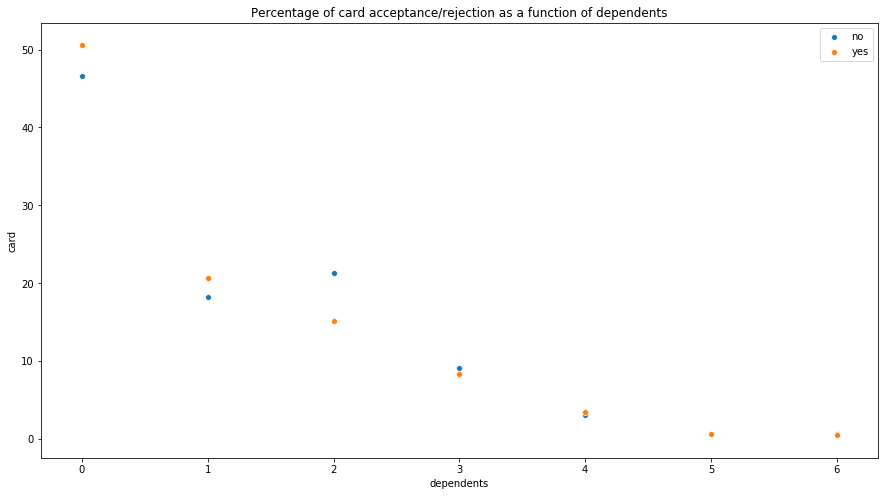

In [454]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x=count_no_by_dependent.index, y=count_no_by_dependent['card']*100/296, label='no')
sns.scatterplot(x=count_yes_by_dependent.index, y=count_yes_by_dependent['card']*100/1023, label='yes')
plt.title('Percentage of card acceptance/rejection as a function of dependents')
plt.show()

In [455]:
count_yes_by_selfemp = data_values[data_values['card']=='yes'].groupby('selfemp').count()
count_no_by_selfemp = data_values[data_values['card']=='no'].groupby('selfemp').count()

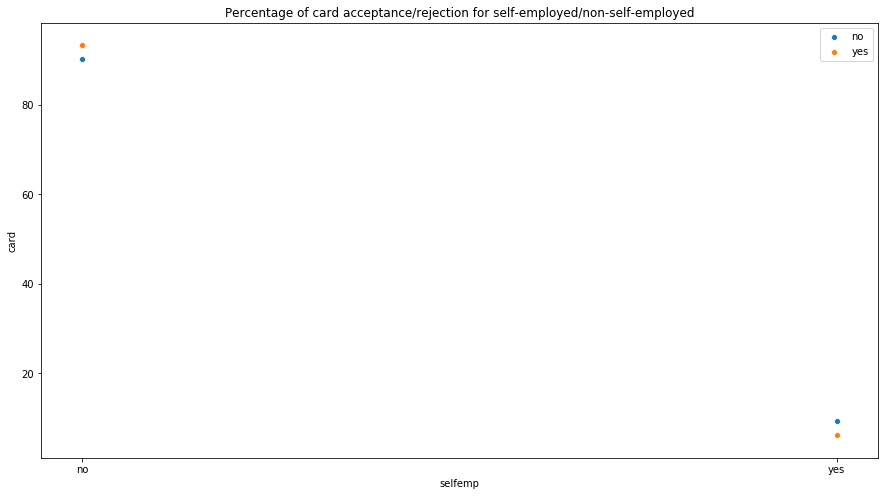

In [456]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x=count_no_by_selfemp.index, y=count_no_by_selfemp['card']*100/296, label='no')
sns.scatterplot(x=count_yes_by_selfemp.index, y=count_yes_by_selfemp['card']*100/1023, label='yes')
plt.title('Percentage of card acceptance/rejection for self-employed/non-self-employed')
plt.show()

In [457]:
count_yes_by_owner = data_values[data_values['card']=='yes'].groupby('owner').count()
count_no_by_owner = data_values[data_values['card']=='no'].groupby('owner').count()

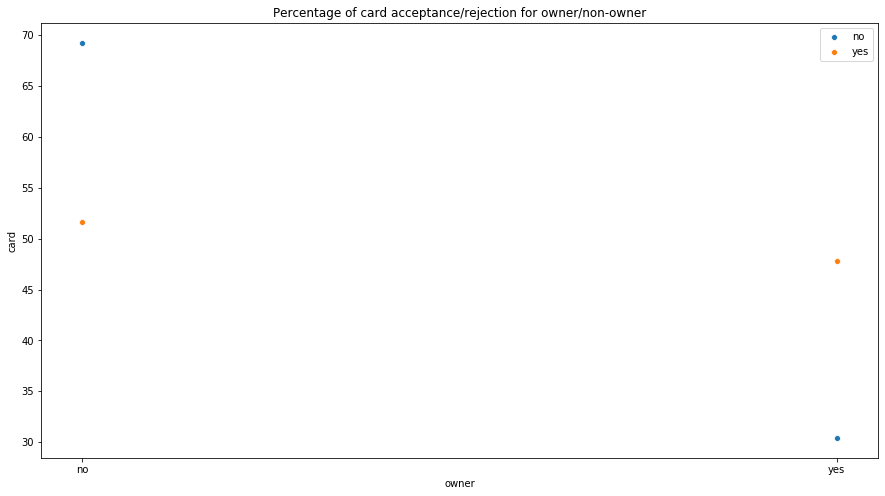

In [458]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x=count_no_by_owner.index, y=count_no_by_owner['card']*100/296, label='no')
sns.scatterplot(x=count_yes_by_owner.index, y=count_yes_by_owner['card']*100/1023, label='yes')
plt.title('Percentage of card acceptance/rejection for owner/non-owner')
plt.show()

# Exploratory analysis

In [459]:
data_values.groupby(['reports','card']).count()

age  income  share  expenditure  owner  selfemp  dependents  \
reports card                                                                
0       no    144     144    144          144    144      144         144   
        yes   910     910    910          910    910      910         910   
1       no     47      47     47           47     47       47          47   
        yes    89      89     89           89     89       89          89   
2       no     37      37     37           37     37       37          37   
        yes    13      13     13           13     13       13          13   
3       no     20      20     20           20     20       20          20   
        yes     4       4      4            4      4        4           4   
4       no     16      16     16           16     16       16          16   
        yes     1       1      1            1      1        1           1   
5       no     11      11     11           11     11       11          11   
6       no      5       5      5            5      5        5           5   
7       no      6       6      6            6      6        6           6   
9       no      2       2      2            2      2        2           2   
10      no      1       1      1            1      1        1           1   
11      no      4       4      4            4      4        4           4   
12      no      1       1      1            1      1        1           1   
14      no      1       1      1            1      1        1           1   

              months  majorcards  active  
reports card                              
0       no       144         144     144  
        yes      910         910     910  
1       no        47          47      47  
        yes       89          89      89  
2       no        37          37      37  
        yes       13          13      13  
3       no        20          20      20  
        yes        4           4       4  
4       no        16          16      16  
        yes        1           1       1  
5       no        11          11      11  
6       no         5           5       5  
7       no         6           6       6  
9       no         2           2       2  
10      no         1           1       1  
11      no         4           4       4  
12      no         1           1       1  
14      no         1           1       1

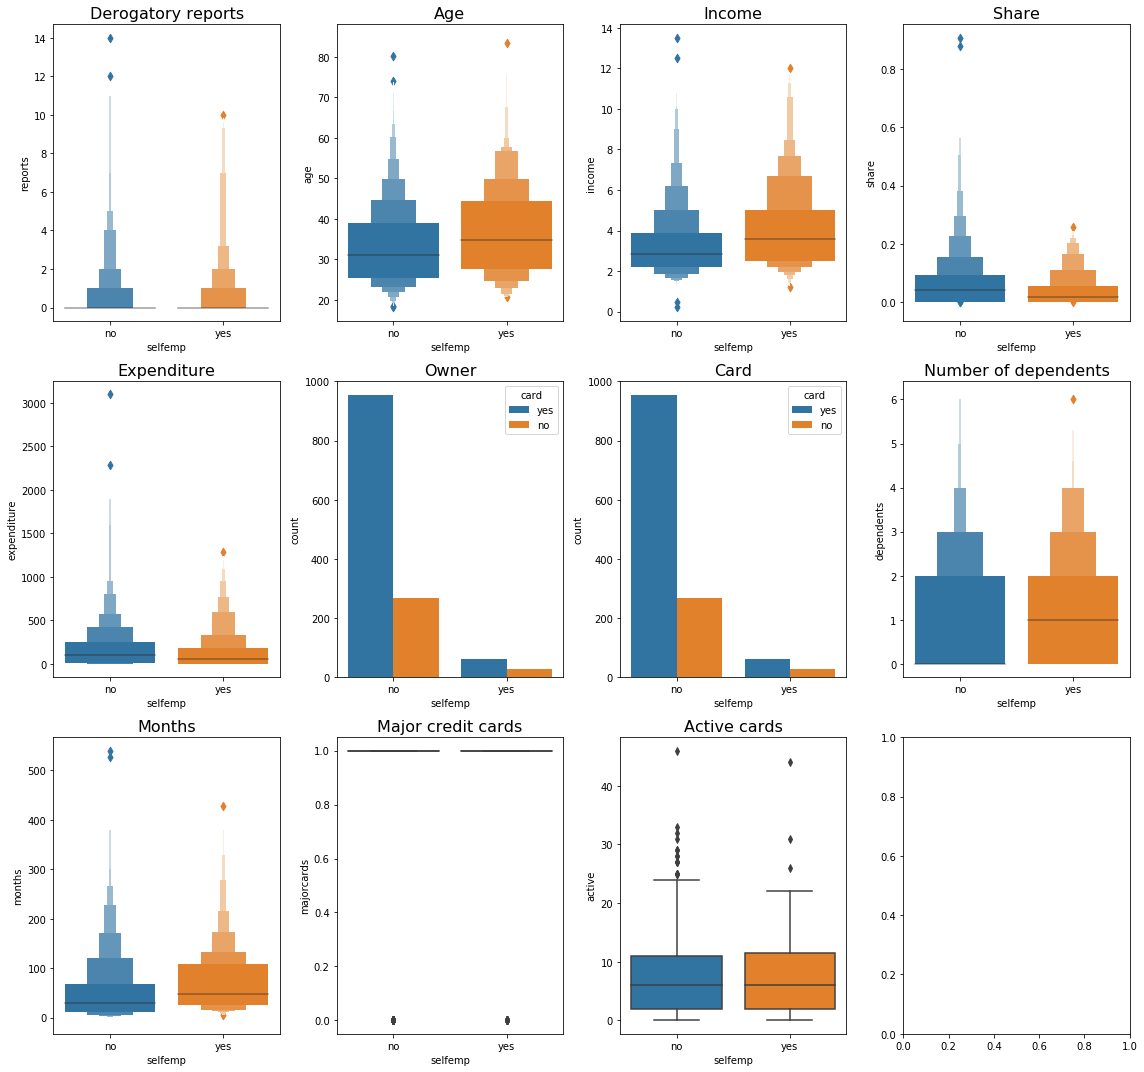

In [460]:
f, axes = plt.subplots(3, 4, figsize=(16,15))

sns.boxenplot(x='selfemp', y='reports', data=data_values, ax=axes[0,0])
axes[0, 0].set_title("Derogatory reports", fontsize=16)

sns.boxenplot(x='selfemp', y='age', data=data_values, ax=axes[0,1])
axes[0, 1].set_title("Age", fontsize=16)

sns.boxenplot(x='selfemp', y='income', data=data_values, ax=axes[0,2])
axes[0, 2].set_title("Income", fontsize=16)

sns.boxenplot(x='selfemp', y='share', data=data_values, ax=axes[0,3])
axes[0, 3].set_title("Share", fontsize=16)

sns.boxenplot(x='selfemp', y='expenditure', data=data_values, ax=axes[1,0])
axes[1, 0].set_title("Expenditure", fontsize=16)

sns.countplot(x='selfemp', hue='card', data=data_values, ax=axes[1,1])
axes[1, 1].set_title("Owner", fontsize=16)

sns.countplot(x='selfemp', hue='card', data=data_values, ax=axes[1,2])
axes[1, 2].set_title("Card", fontsize=16)

sns.boxenplot(x='selfemp', y='dependents', data=data_values, ax=axes[1,3])
axes[1, 3].set_title("Number of dependents", fontsize=16)

sns.boxenplot(x='selfemp', y='months', data=data_values, ax=axes[2,0])
axes[2, 0].set_title("Months", fontsize=16)

sns.boxplot(x='selfemp', y='majorcards', data=data_values, ax=axes[2,1])
axes[2, 1].set_title("Major credit cards", fontsize=16)

sns.boxplot(x='selfemp', y='active', data=data_values, ax=axes[2,2])
axes[2, 2].set_title("Active cards", fontsize=16)

plt.tight_layout()

# Modeling risk

In [461]:
data_values.groupby('card').count()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
card,,,,,,,,,,,
no,295,295,295,295,295,295,295,295,295,295,295
yes,1017,1017,1017,1017,1017,1017,1017,1017,1017,1017,1017


In [495]:
print(295/(1017+295))
print(1017/(1017+295))

0.22484756097560976
0.7751524390243902


The proportion of rejected/accepted cards with respect to the total number of applications is 22.4% and 77.6%, respectively. On the one hand, this implies that a learner that always accepts an application will correctly classify 77.6% of applications. Any other learner has to be compared against this default learner. On the other hand, this is an empirical measure of overall risk, which we can identify as middle risk.

The categorical variables have to be encoded. Since all sets of categories are binary, it is enough if `yes` is translated as `1` and `no` is translated as `0`.

In [463]:
def encode_yes_no(value):
    return 1 if value == 'yes' else 0

In [464]:
data_values['encoded_card'] = data_values['card'].apply(encode_yes_no)
data_values['encoded_owner'] = data_values['owner'].apply(encode_yes_no)
data_values['encoded_selfemp'] = data_values['selfemp'].apply(encode_yes_no)

/home/paloderosa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/paloderosa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/paloderosa/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [465]:
data_values

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,encoded_card,encoded_owner,encoded_selfemp
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1,1,0
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1,0,0
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1,1,0
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1,0,0
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19,1,1,0
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5,0,0,0
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2,1,1,0
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7,1,0,1


In [466]:
print(data_values[(data_values['owner']=='yes') & (data_values['card']=='yes')]['card'].count() / data_values[(data_values['owner']=='yes')]['card'].count())
print(data_values[(data_values['owner']=='no') & (data_values['card']=='yes')]['card'].count() / data_values[(data_values['owner']=='no')]['card'].count())

0.844559585492228
0.7203274215552524


In [467]:
y = data_values['encoded_card'].values
X = data_values[[
    'reports', 
    'age', 
    'income', 
    'encoded_owner', 
    'encoded_selfemp', 
    'dependents', 
    'months', 
    'majorcards', 
    'active']].values

In [468]:
test_size = 0.25
seed = 7

In [469]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

## Gradient boosting

In [470]:
model_gb = XGBClassifier()
model_gb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [471]:
y_pred_gb = model_gb.predict(X_test)

In [472]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_score_gb = f1_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy_gb * 100.0:.2f}")
print(f"F1: {f1_score_gb * 100.0:.2f}")

Accuracy: 88.41
F1: 93.12


## Neural network

In [473]:
model_nn = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=(100, 30, 8), max_iter=10000, learning_rate='adaptive')

In [474]:
model_nn.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 30, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [475]:
y_pred_nn = model_nn.predict(X_test)

In [476]:
accuracy_nn = accuracy_score(y_test, y_pred_nn)
f1_score_nn = f1_score(y_test, y_pred_nn)
print(f"Accuracy: {accuracy_nn * 100.0:.2f}")
print(f"F1: {f1_score_nn * 100.0:.2f}")

Accuracy: 87.80
F1: 92.83


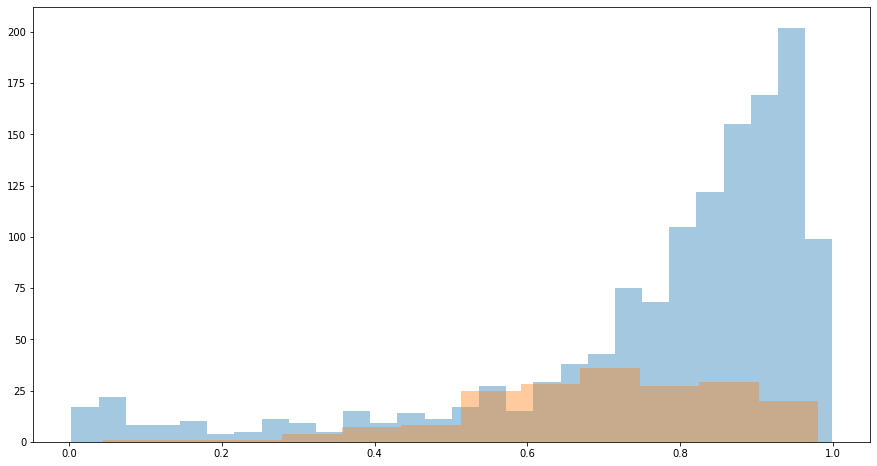

In [477]:
fig = plt.figure(figsize=(15,8))
sns.distplot(model_nn.predict_proba(X)[:,1], kde=False)
sns.distplot(model_nn.predict_proba(X)[np.abs(y - np.round(model_nn.predict(X))) > 0.0, 1], kde=False)

In [478]:
data_description

{'card': 'Dummy variable, 1 if application for credit card accepted, 0 if not',
 'reports': 'Number of major derogatory reports',
 'age': 'Age n years plus twelfths of a year',
 'income': 'Yearly income (divided by 10,000)',
 'share': 'Ratio of monthly credit card expenditure to yearly income',
 'expenditure': 'Average monthly credit card expenditure',
 'owner': '1 if owns their home, 0 if rent',
 'selfempl': '1 if self employed, 0 if not.',
 'dependents': '1 + number of dependents',
 'months': 'Months living at current address',
 'majorcards': 'Number of major credit cards held',
 'active': 'Number of active credit accounts'}

In [479]:
X_reduced = data_values[[
    'encoded_selfemp',
    'reports',
]].values

In [480]:
X_reduced_train, X_reduced_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size)

## Gradient boost with reduced model

In [481]:
model_reduced_gb = XGBClassifier()
model_reduced_gb.fit(X_reduced_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [482]:
y_pred_reduced_gb = model_reduced_gb.predict(X_reduced_test)

In [483]:
accuracy_reduced_gb = accuracy_score(y_test, y_pred_reduced_gb)
f1_score_reduced_gb = f1_score(y_test, y_pred_reduced_gb)
print(f"Accuracy: {accuracy_reduced_gb * 100.0:.2f}")
print(f"F1: {f1_score_reduced_gb * 100.0:.2f}")

Accuracy: 84.76
F1: 90.91


## Neural network with reduced model

In [484]:
model_reduced_nn = MLPClassifier(solver='sgd', alpha=1e-2, hidden_layer_sizes=(100, 30, 8), max_iter=10000, learning_rate='adaptive')

In [485]:
model_reduced_nn.fit(X_reduced_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 30, 8), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='sgd',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [486]:
y_pred_reduced_nn = model_reduced_nn.predict(X_reduced_test)

In [487]:
accuracy_reduced_nn = accuracy_score(y_test, y_pred_reduced_nn)
f1_score_reduced_nn = f1_score(y_test, y_pred_reduced_nn)
print(f"Accuracy: {accuracy_reduced_nn * 100.0:.2f}")
print(f"F1: {f1_score_reduced_nn * 100.0:.2f}")

Accuracy: 84.76
F1: 90.91


# Logistic regression

In [488]:
model_lr = LogisticRegression(penalty='l2', C=1e0)

In [489]:
model_lr.fit(X_reduced_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [490]:
y_pred_lr = model_lr.predict(X_reduced_test)

In [491]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_score_lr = f1_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr * 100.0:.2f}")
print(f"F1: {f1_score_lr * 100.0:.2f}")

Accuracy: 84.76
F1: 90.91


In [492]:
model_lr.coef_

array([[-0.35373233, -1.2318268 ]])

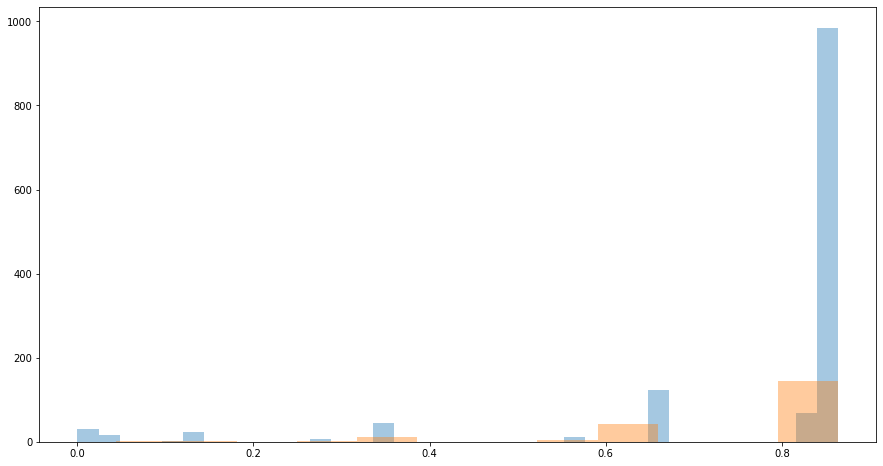

In [493]:
fig = plt.figure(figsize=(15,8))
sns.distplot(model_lr.predict_proba(X_reduced)[:,1], kde=False)
sns.distplot(model_lr.predict_proba(X_reduced)[np.abs(y - np.round(model_lr.predict(X_reduced))) > 0.0, 1], kde=False)

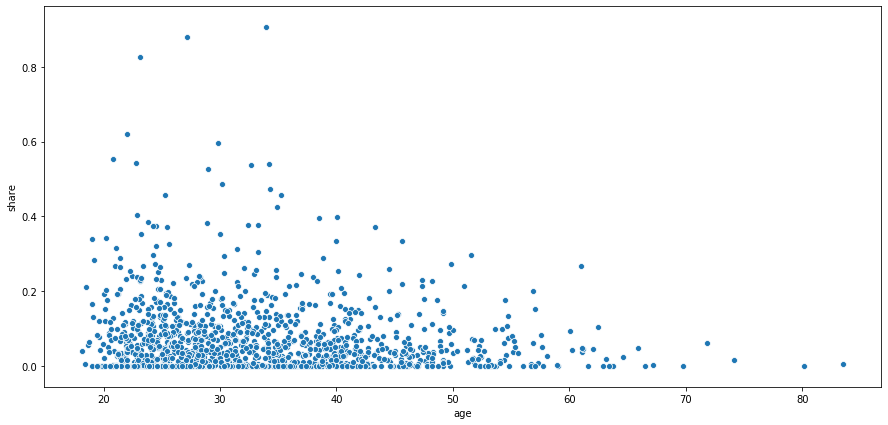

In [494]:
fig = plt.figure(figsize=(15,7))
sns.scatterplot(x='age', y='share', data=data_values)

# On the significance of `selfemp`

In [241]:
data_description

{'card': 'Dummy variable, 1 if application for credit card accepted, 0 if not',
 'reports': 'Number of major derogatory reports',
 'age': 'Age n years plus twelfths of a year',
 'income': 'Yearly income (divided by 10,000)',
 'share': 'Ratio of monthly credit card expenditure to yearly income',
 'expenditure': 'Average monthly credit card expenditure',
 'owner': '1 if owns their home, 0 if rent',
 'selfempl': '1 if self employed, 0 if not.',
 'dependents': '1 + number of dependents',
 'months': 'Months living at current address',
 'majorcards': 'Number of major credit cards held',
 'active': 'Number of active credit accounts'}

In [239]:
from scipy.stats import kruskal

## Card

In [240]:
kruskal(
    data_values[data_values['selfemp']=='yes']['card'],
    data_values[data_values['selfemp']=='no']['card']
)

KruskalResult(statistic=3.891892189779965, pvalue=0.048519729674888414)

## Reports

In [242]:
kruskal(
    data_values[data_values['selfemp']=='yes']['reports'],
    data_values[data_values['selfemp']=='no']['reports']
)

KruskalResult(statistic=1.1387072806461134, pvalue=0.2859256514017401)

In [322]:
print(data_values[data_values['selfemp']=='yes']['reports'].count())
print(data_values[data_values['selfemp']=='no']['reports'].count())

91
1228


## Age

In [243]:
kruskal(
    data_values[data_values['selfemp']=='yes']['age'],
    data_values[data_values['selfemp']=='no']['age']
)

KruskalResult(statistic=10.27064530658571, pvalue=0.001351635191423573)

## Income

In [244]:
kruskal(
    data_values[data_values['selfemp']=='yes']['income'],
    data_values[data_values['selfemp']=='no']['income']
)

KruskalResult(statistic=14.279292553400655, pvalue=0.00015758901204241055)

In [324]:
print(data_values[data_values['selfemp']=='yes']['income'].mean())
print(data_values[data_values['selfemp']=='no']['income'].mean())

4.063864835164836
3.31361506514658


## Share

In [246]:
kruskal(
    data_values[(data_values['selfemp']=='yes') & (data_values['card']=='yes')]['share'],
    data_values[(data_values['selfemp']=='no') & (data_values['card']=='yes')]['share']
)

KruskalResult(statistic=8.899067233534126, pvalue=0.0028531636625181494)

In [325]:
print(data_values[(data_values['selfemp']=='yes') & (data_values['card']=='yes')]['share'].mean())
print(data_values[(data_values['selfemp']=='no') & (data_values['card']=='yes')]['share'].mean())

0.059463644285714275
0.09038582845625001


In [247]:
kruskal(
    data_values[(data_values['selfemp']=='yes') & (data_values['card']=='yes')]['expenditure'],
    data_values[(data_values['selfemp']=='no') & (data_values['card']=='yes')]['expenditure']
)

KruskalResult(statistic=1.9631210727979562, pvalue=0.1611799183324186)

In [248]:
kruskal(
    data_values[(data_values['selfemp']=='yes') & (data_values['card']=='yes')]['dependents'],
    data_values[(data_values['selfemp']=='no') & (data_values['card']=='yes')]['dependents']
)

KruskalResult(statistic=2.3041097498722887, pvalue=0.12903219027055557)

In [250]:
kruskal(
    data_values[data_values['selfemp']=='yes']['months'],
    data_values[data_values['selfemp']=='no']['months']
)

KruskalResult(statistic=17.43903733423302, pvalue=2.966702455417066e-05)

In [251]:
kruskal(
    data_values[data_values['selfemp']=='yes']['active'],
    data_values[data_values['selfemp']=='no']['active']
)

KruskalResult(statistic=0.45025406217499875, pvalue=0.5022143289807612)

In terms of financials, the income is higher for the self-employed (40K vs 33K), while the share is also higher for the self-employed, that is, a larger proportion of their income is spent using credit cards.

# Clustering

In [273]:
from sklearn.cluster import KMeans

In [290]:
clusterer = KMeans(4, random_state=1)

In [291]:
clusterer.fit(X_reduced)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [292]:
data_values['cluster'] = clusterer.predict(X_reduced)

In [293]:
group_by_cluster = data_values.groupby(['cluster','card']).count()
group_by_cluster

reports  age  income  share  expenditure  owner  selfemp  \
cluster card                                                             
0       no        145  145     145    145          145    145      145   
        yes       915  915     915    915          915    915      915   
1       no         58   58      58     58           58     58       58   
        yes         5    5       5      5            5      5        5   
2       no          9    9       9      9            9      9        9   
3       no         84   84      84     84           84     84       84   
        yes       103  103     103    103          103    103      103   

              dependents  months  majorcards  active  encoded_card  \
cluster card                                                         
0       no           145     145         145     145           145   
        yes          915     915         915     915           915   
1       no            58      58          58      58            58   
        yes            5       5           5       5             5   
2       no             9       9           9       9             9   
3       no            84      84          84      84            84   
        yes          103     103         103     103           103   

              encoded_owner  encoded_selfemp  
cluster card                                  
0       no              145              145  
        yes             915              915  
1       no               58               58  
        yes               5                5  
2       no                9                9  
3       no               84               84  
        yes             103              103

In [284]:
group_by_cluster.loc[(0,'yes'),'reports']

1005

In [435]:
print(f"card acceptance rate for cluster 0: {group_by_cluster.loc[(0,'yes'),'reports']/(group_by_cluster.loc[(0,'yes'),'reports'] + group_by_cluster.loc[(0,'no'),'reports'])}")
print(f"card acceptance rate for cluster 1: {group_by_cluster.loc[(1,'yes'),'reports']/(group_by_cluster.loc[(1,'yes'),'reports'] + group_by_cluster.loc[(1,'no'),'reports'] + group_by_cluster.loc[(2,'no'),'reports'])}")
print(f"card acceptance rate for cluster 2: {group_by_cluster.loc[(3,'yes'),'reports']/(group_by_cluster.loc[(3,'yes'),'reports'] + group_by_cluster.loc[(3,'no'),'reports'])}")

card acceptance rate for cluster 0: 0.8632075471698113
card acceptance rate for cluster 1: 0.06944444444444445
card acceptance rate for cluster 2: 0.5508021390374331


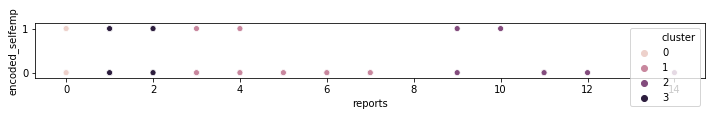

In [304]:
fig = plt.figure(figsize=(12,1))
sns.scatterplot(x='reports', y='encoded_selfemp', hue='cluster', data=data_values)

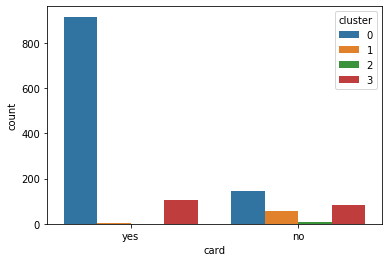

In [296]:
sns.countplot('card', hue='cluster', data=data_values)

# Observations

1. The two most predictive features for `card` taken as a measure of risk are `reports` followed by `selfemp`.
2. The features for which there exist differences between self-employed and non self-employed `card`, `age`, `income`, `share` and `active`.
3. A simple classification model for `card` that performs better than default can be built using logistic regression with `reports` and `selfemp` as features.
4. As the age increases, the share decreases.
5. The acceptance rate is 77%. If we take this as a measure of default, which is polemical, and we gave a credit to each person for the same amount, the interest rate without operative costs would have to be approximately 30% on the total amount.